In [162]:
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import pandas as pd  # Importing pandas for easier CSV file handling

# New file path and encoding
dvm_filepath = '3458 Mesures (3 DVM) Valerio-100mV-2days-data-start20231013-174527-end20231016-010207.slp'

# Read the file with the specified encoding
with open(dvm_filepath, 'r', encoding='iso-8859-1') as file:
    lines = file.readlines()

# Mapping block identifiers to meaningful names
block_names = {
    'b7': 'dvm1_voltage',
    'b8': 'dvm2_voltage',
    'b9': 'dvm3_voltage',
    'b10': 'dvm1_pp',
    'b11': 'dvm2_pp',
    'b12': 'dvm3_pp',
    'b13': 'dvm1_temp',
    'b14': 'dvm2_temp',
    'b15': 'dvm3_temp',
}

# Process the data
def process_data(lines):
    data = {}
    current_block = None
    
    for line in lines:
        line = line.strip()

        # Check for block identifier
        if re.match(r'b\d+', line):
            if current_block is not None and len(current_block['data']) > 2:
                block_name = block_names.get(current_block['name'])
                if block_name:  # Check if the block name is in the mapping
                    data[block_name] = current_block['data'][2:]  # Skip the first two elements
                
            current_block = {'name': line, 'data': [], 'skip_lines': 2}
            continue
        
        # Skip the defined number of lines after each data block identifier
        if current_block is not None and current_block['skip_lines'] > 0:
            current_block['skip_lines'] -= 1
            continue

        # Add data lines to the current block
        if current_block is not None and re.match(r'[-]?\d+\.?\d*', line):
            current_block['data'].append(float(line))
            
    if current_block is not None and len(current_block['data']) > 2:
        block_name = block_names.get(current_block['name'])
        if block_name:  # Check if the block name is in the mapping
            data[block_name] = current_block['data'][2:]  # Skip the first two elements

    return data

# Load temperature data from the two new CSV files
def load_temperature_data(filename, rows_to_skip=0):
    # Skipping the first 7 rows as they do not contain data
    df = pd.read_csv(filename, skiprows=rows_to_skip)
    temperatures = df['Temperature (°C)'].to_numpy()  # Convert temperature column to numpy array
    timestamp_strings = df['Date / Time (UTC)'].to_numpy()  # Get timestamp column as numpy array
    
    # Convert timestamp strings to datetime objects
    timestamps = np.array([datetime.strptime(ts, '%Y/%m/%d %H:%M:%S') for ts in timestamp_strings]) + timedelta(hours=2)
    
    
    return temperatures, timestamps


# Processed data blocks with meaningful names as keys
data_blocks = process_data(lines)

# Extract the data into individual variables
dvm1_voltage = np.array(data_blocks.get('dvm1_voltage', []))
dvm2_voltage = np.array(data_blocks.get('dvm2_voltage', []))
dvm3_voltage = np.array(data_blocks.get('dvm3_voltage', []))
dvm1_pp = np.array(data_blocks.get('dvm1_pp', []))
dvm2_pp = np.array(data_blocks.get('dvm2_pp', []))
dvm3_pp = np.array(data_blocks.get('dvm3_pp', []))
dvm1_temp = np.array(data_blocks.get('dvm1_temp', []))
dvm2_temp = np.array(data_blocks.get('dvm2_temp', []))
dvm3_temp = np.array(data_blocks.get('dvm3_temp', []))
# Filename for Fluke DVM
fluke_filename = 'RECORD_20231016080424.csv'


# Loading data from the CSV file into a numpy array
fluke_data = np.loadtxt(fluke_filename, delimiter=',')

fluke_volts_readings = fluke_data

# Loading temperature data
oven_temperatures, oven_timestamps = load_temperature_data('temperature-oven.csv',11)
room_temperatures, room_timestamps = load_temperature_data('temperature-room.csv',10)

# We trim the first 70 minutes of time because that was settling time after the loggers were handled, and the last 5 minutes for the same reason
POS_TRIM = 70
NEG_TRIM = -5

# discard the first 2 hours and last 10 minutes of the oven temperature data
oven_temperatures_trim = oven_temperatures[POS_TRIM: NEG_TRIM]
oven_timestamps_trim = oven_timestamps[POS_TRIM: NEG_TRIM]

# discard the first 2 hours and last 10 minutes of the room temperature data
room_temperatures_trim = room_temperatures[POS_TRIM: NEG_TRIM]
room_timestamps_trim = room_timestamps[POS_TRIM: NEG_TRIM]

# Print out some values to verify
print("\nOven Temperatures Data:")
print("Oven temperatures:", oven_temperatures[:5])
print("Length of oven temperatures:", len(oven_temperatures))

print("\nRoom Temperatures Data:")
print("Room temperatures:", room_temperatures[:5])
print("Length of room temperatures:", len(room_temperatures))


# Print out some values to verify
print("\nFluke DVM Data:")
print("Fluke Volt readings:", fluke_volts_readings[:5])
print("Length of fluke volts readings:", len(fluke_volts_readings))

# Print lengths to verify
print("Length of DVM1 Voltage:", len(dvm1_voltage))
print("DVM1 sample of 5 readings:", dvm1_voltage[:5])
print("Length of DVM2 Voltage:", len(dvm2_voltage))
print("Length of DVM3 Voltage:", len(dvm3_voltage))
print("Length of DVM1 PP:", len(dvm1_pp))
print("Length of DVM2 PP:", len(dvm2_pp))
print("Length of DVM3 PP:", len(dvm3_pp))
print("Length of DVM1 Temperature:", len(dvm1_temp))
print("Length of DVM2 Temperature:", len(dvm2_temp))
print("Length of DVM3 Temperature:", len(dvm3_temp))



Oven Temperatures Data:
Oven temperatures: [28.21 28.45 28.79 29.02 29.24]
Length of oven temperatures: 3862

Room Temperatures Data:
Room temperatures: [25.82 26.02 26.09 26.65 26.63]
Length of room temperatures: 3866

Fluke DVM Data:
Fluke Volt readings: [1.7945e-05 1.7860e-05 1.7760e-05 1.7812e-05 1.7826e-05]
Length of fluke volts readings: 23145
Length of DVM1 Voltage: 19901
DVM1 sample of 5 readings: [1.89170647e-05 1.91446401e-05 1.89838073e-05 1.90040271e-05
 1.90220282e-05]
Length of DVM2 Voltage: 19901
Length of DVM3 Voltage: 19901
Length of DVM1 PP: 19901
Length of DVM2 PP: 19901
Length of DVM3 PP: 19901
Length of DVM1 Temperature: 19901
Length of DVM2 Temperature: 19901
Length of DVM3 Temperature: 19901


In [163]:
import matplotlib.dates as mdates

# Known start time for DVM data
dvm_start_time = datetime(2023, 10, 13, 17, 45, 13)

# Known end time for the fluke data
fluke_timestamp_str = fluke_filename.split('_')[1].split('.')[0]
fluke_end_time = datetime.strptime(fluke_timestamp_str, '%Y%m%d%H%M%S')

# add 2h to the fluke end time to account for the wrong time setting
fluke_end_time += timedelta(hours=2)

# Creating a numpy array of timestamps for the DVM data
dvm_timestamps = np.array([dvm_start_time + timedelta(seconds=i*10) for i in range(len(dvm1_voltage))])

# Creating a numpy array of timestamps for the Fluke DVM data, knowing the end time and the 10s interval
fluke_timestamps = np.array([fluke_end_time - timedelta(seconds=i*10) for i in range(len(fluke_volts_readings), 0, -1)])

# Determining the overlapping time range
start_time = max(dvm_timestamps[0], fluke_timestamps[0])  # The later start time
end_time = min(dvm_timestamps[-1], fluke_timestamps[-1])  # The earlier end time



# Print the start and end times to verify
print("\nStart time:", start_time)
print("End time:", end_time)

# Filtering the DVM data to the overlapping range
dvm_overlap_mask = (dvm_timestamps >= start_time) & (dvm_timestamps <= end_time)
dvm_overlap_timestamps = dvm_timestamps[dvm_overlap_mask]
dvm1_voltage_overlap = dvm1_voltage[dvm_overlap_mask]
dvm2_voltage_overlap = dvm2_voltage[dvm_overlap_mask]
dvm3_voltage_overlap = dvm3_voltage[dvm_overlap_mask]

# Filtering the Fluke DVM data to the overlapping range
fluke_overlap_mask = (fluke_timestamps >= start_time) & (fluke_timestamps <= end_time)
fluke_overlap_timestamps = fluke_timestamps[fluke_overlap_mask]
fluke_volts_overlap = fluke_volts_readings[fluke_overlap_mask]




Start time: 2023-10-13 17:46:54
End time: 2023-10-16 01:01:53


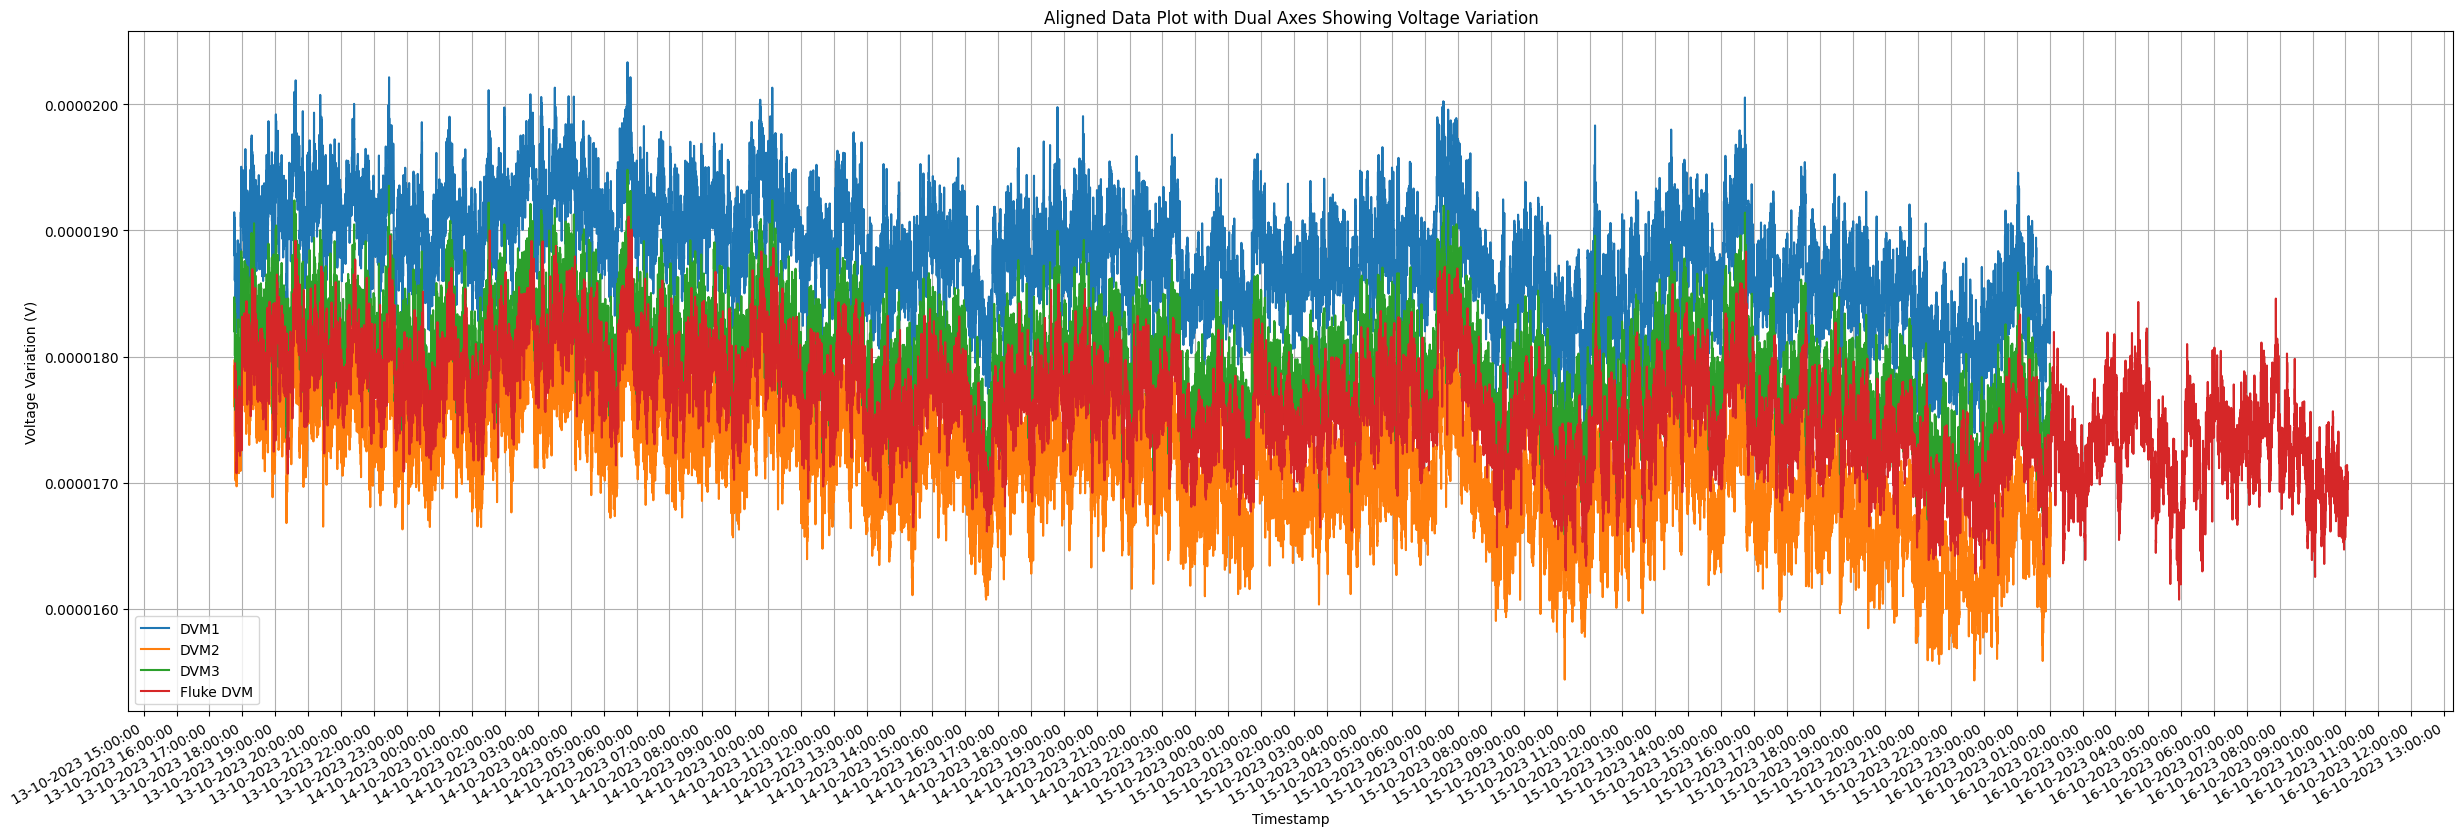

In [164]:

import matplotlib.dates as mdates

# Plotting the data with two different scales
plt.figure(figsize=(30, 10))

def remove_outliers_and_extend_with_mean(data):
  # whenever we encounter an outlier data, we replace it with the mean of the previous and next data
  # this is to avoid the plot from having a sharp drop or rise

  # first, we calculate the sigma of the data
  sigma = np.std(data)

  # then we calculate the mean of the data
  mean = np.mean(data)

  # if a value is outside 6 sigma, we replace it with the mean of the previous and next data. if the value is at the start or end of the data, we replace it with the next or previous data respectively. handle both positive and negative outliers. create a new array to store the data
  new_data = []
  for i in range(len(data)):
    if i == 0:
      if abs(data[i] - mean) > 6 * sigma:
        new_data.append(data[i + 1])
      else:
        new_data.append(data[i])
    elif i == len(data) - 1:
      if abs(data[i] - mean) > 6 * sigma:
        new_data.append(data[i - 1])
      else:
        new_data.append(data[i])
    else:
      if abs(data[i] - mean) > 6 * sigma:
        new_data.append((data[i - 1] + data[i + 1]) / 2)
      else:
        new_data.append(data[i])

  return np.array(new_data)

dvm1_voltage_clean = remove_outliers_and_extend_with_mean(dvm1_voltage)
dvm2_voltage_clean = remove_outliers_and_extend_with_mean(dvm2_voltage)
dvm3_voltage_clean = remove_outliers_and_extend_with_mean(dvm3_voltage)
fluke_voltage_clean = remove_outliers_and_extend_with_mean(fluke_volts_readings)


# Plot all DVM voltage variations, without filtering for overlapping timestamps
plt.plot(dvm_timestamps, dvm1_voltage_clean, label='DVM1')
plt.plot(dvm_timestamps, dvm2_voltage_clean, label='DVM2')
plt.plot(dvm_timestamps, dvm3_voltage_clean, label='DVM3')
plt.plot(fluke_timestamps, fluke_voltage_clean, label='Fluke DVM')

# Labeling and formatting for this y-axis
plt.xlabel('Timestamp')
plt.ylabel('Voltage Variation (V)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

plt.grid(True)

# Auto format the x-axis labels to fit them better
plt.gcf().autofmt_xdate()

# force y axis to show 10 decimal places
plt.gca().yaxis.set_major_formatter('{:.7f}'.format)

# Show only DVM data in the legend
plt.legend(loc='lower left')

# Add a title
plt.title('Aligned Data Plot with Dual Axes Showing Voltage Variation')

# Show plot
plt.show()

DVM slope: -14.7036 ppm/year
Fluke DVM slope: -11.9515 ppm/year


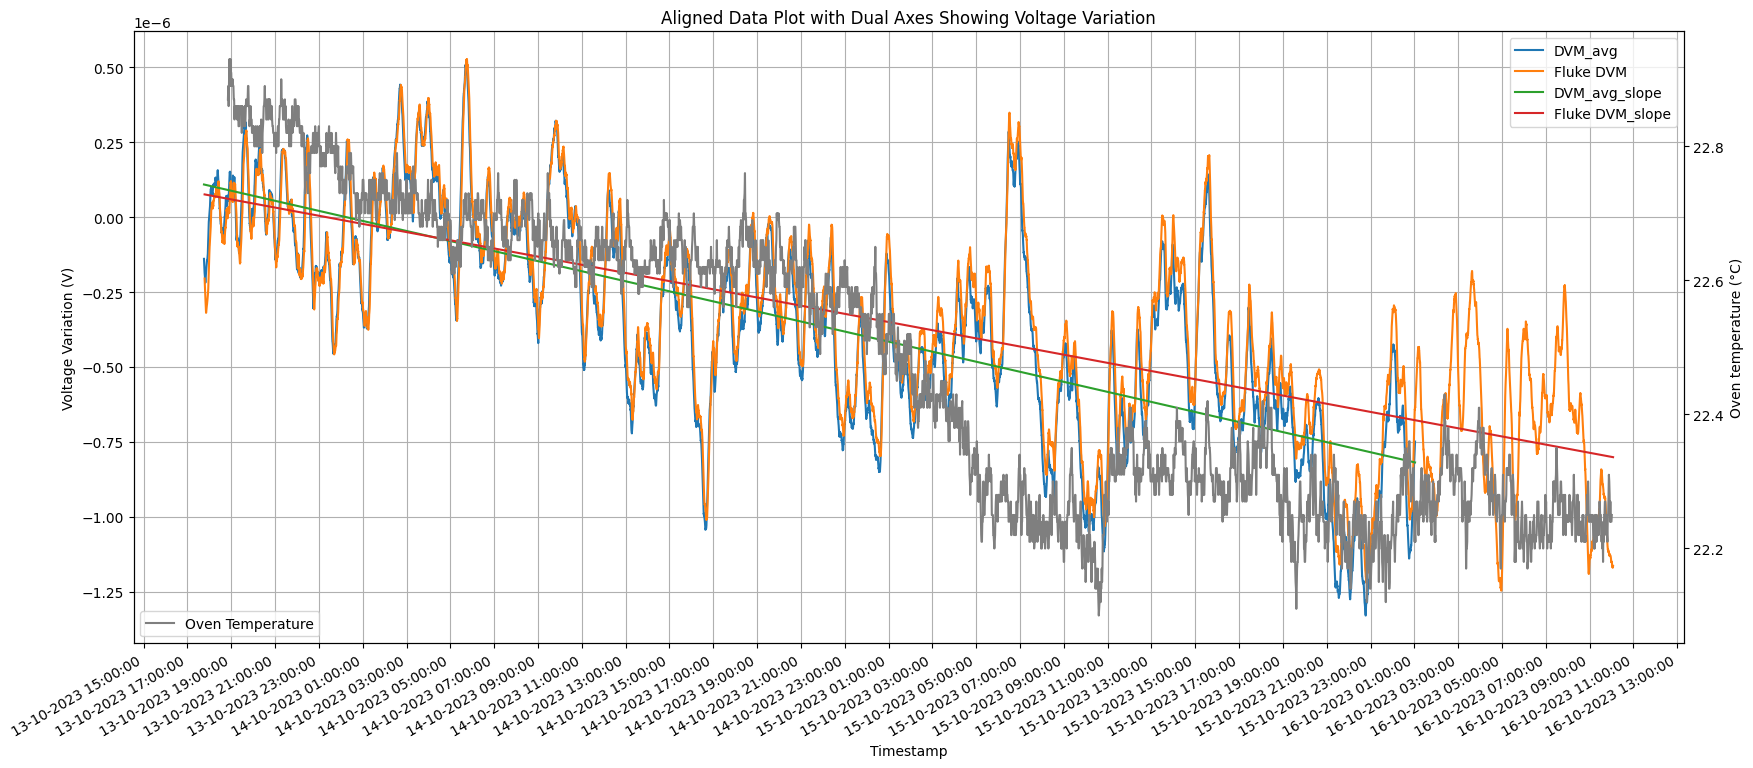

In [171]:

import matplotlib.dates as mdates

# Plotting the data with two different scales
plt.figure(figsize=(20, 9))


FILTER = 100
# we use a centered moving average to smooth the data withour introducing a lag
def centered_moving_average(data, window_size):
    """Compute a centered moving average."""
    half_window = window_size // 2
    extended_data = np.pad(data, (half_window, half_window), mode='edge')
    cumsum = np.cumsum(extended_data)
    
    # Subtract the cumulated sum shifted by the window size from the cumulated sum 
    # to get the sum over the window for each point
    sum_window = cumsum[window_size:] - cumsum[:-window_size]
    return sum_window / window_size

# average the three DVM data together
dvm_voltage = (dvm1_voltage + dvm2_voltage + dvm3_voltage) / 3
fluke_voltage_variation = fluke_volts_readings - fluke_volts_readings[0]

dvm_voltage_variation = dvm_voltage - dvm_voltage[0]

dvm_voltage_variation_clean = remove_outliers_and_extend_with_mean(dvm_voltage_variation)

fluke_voltage_variation_clean = remove_outliers_and_extend_with_mean(fluke_voltage_variation)

dvm_voltage_variation_clean_avg = centered_moving_average(dvm_voltage_variation_clean, FILTER)
fluke_voltage_variation_clean_avg = centered_moving_average(fluke_voltage_variation_clean, FILTER)


# Plot all DVM voltage variations, without filtering for overlapping timestamps
plt.plot(dvm_timestamps, dvm_voltage_variation_clean_avg, label='DVM_avg')
plt.plot(fluke_timestamps, fluke_voltage_variation_clean_avg, label='Fluke DVM')

# Labeling and formatting for this y-axis
plt.xlabel('Timestamp')
plt.ylabel('Voltage Variation (V)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))

plt.grid(True)

# Auto format the x-axis labels to fit them better
plt.gcf().autofmt_xdate()

# calculate the linear regression of the DVM data
dvm_timestamps_float = mdates.date2num(dvm_timestamps)
dvm_slope, dvm_intercept = np.polyfit(dvm_timestamps_float, dvm_voltage_variation_clean_avg, 1)

# calculate the linear regression of the Fluke DVM data
fluke_timestamps_float = mdates.date2num(fluke_timestamps) 

fluke_slope, fluke_intercept = np.polyfit(fluke_timestamps_float, fluke_voltage_variation_clean_avg, 1)

# plot the linear regression lines
plt.plot(dvm_timestamps, dvm_slope * dvm_timestamps_float + dvm_intercept, label='DVM_avg_slope')
plt.plot(fluke_timestamps, fluke_slope * fluke_timestamps_float + fluke_intercept, label='Fluke DVM_slope')

# print the slopes in uV/year
print("DVM slope: {:.4f} ppm/year".format(dvm_slope * 1e5*365))
print("Fluke DVM slope: {:.4f} ppm/year".format(fluke_slope * 1e5 *365))

# Show only DVM data in the legend
plt.legend(loc='upper right')

# plot the room temperature and the oven temperature on the second y axis
ax2 = plt.twinx()

# plot the room temperature and the oven temperature on the second y axis
# set the color index to 3 
ax2.plot(room_timestamps_trim, room_temperatures_trim, label='Oven Temperature', color='C7')

ax2.set_ylabel('Oven temperature (°C)')

plt.legend(loc='lower left')



# Add a title
plt.title('Aligned Data Plot with Dual Axes Showing Voltage Variation')

# save png
plt.savefig('aligned_data_plot.png', dpi=300)

# Show plot
plt.show()

The plot above shows a projection for -14.7 ppm/year, that is clearly above the PBC spec (that is only +-1ppm/year)

Moreover, there looks to be a correlation between the temperature and the voltage, meaning that what we see may be because of the temperature coefficient of the DVMs.

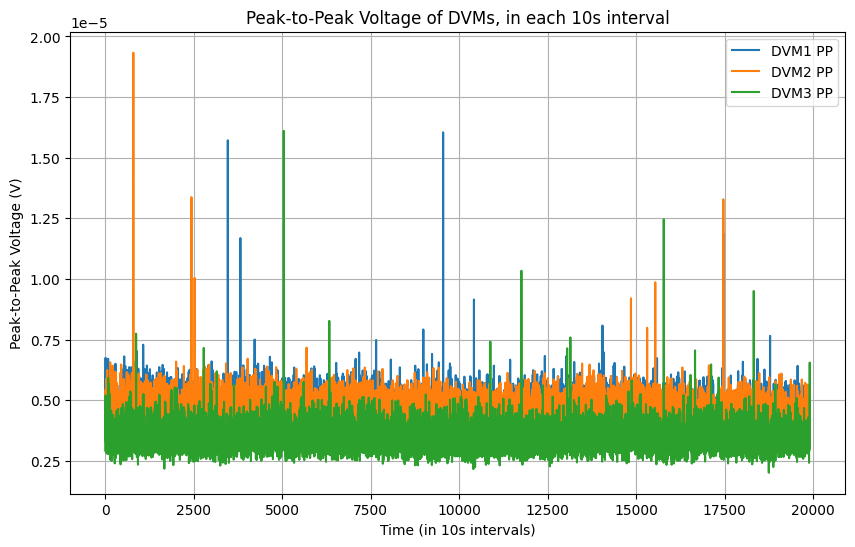

In [166]:

# Plot PP
plt.figure(figsize=(10, 6))

dvm1_pp_clean = remove_outliers_and_extend_with_mean(dvm1_pp)
dvm2_pp_clean = remove_outliers_and_extend_with_mean(dvm2_pp)
dvm3_pp_clean = remove_outliers_and_extend_with_mean(dvm3_pp)


plt.plot(dvm1_pp_clean, label='DVM1 PP')
plt.plot(dvm2_pp_clean, label='DVM2 PP')
plt.plot(dvm3_pp_clean, label='DVM3 PP')
plt.title('Peak-to-Peak Voltage of DVMs, in each 10s interval')
plt.xlabel('Time (in 10s intervals)')
plt.ylabel('Peak-to-Peak Voltage (V)')
plt.legend()
plt.grid(True)
plt.show()


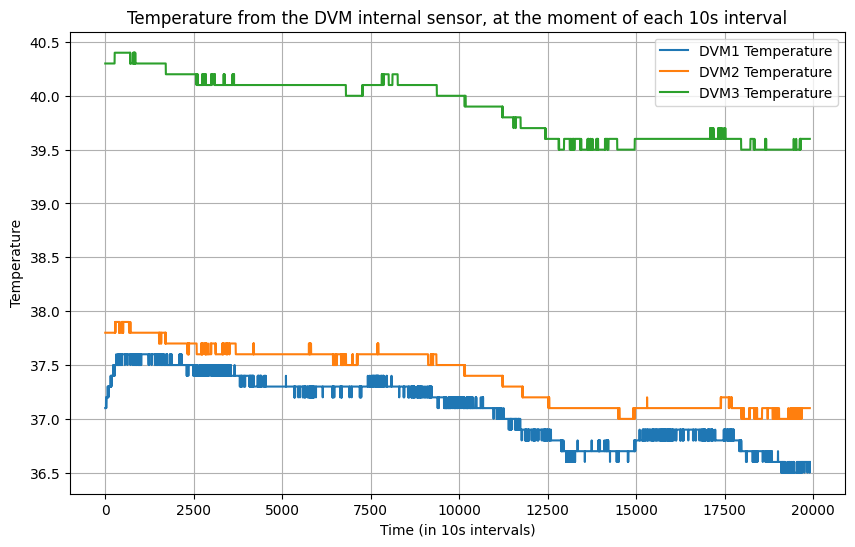

In [167]:

# Plot temperatures
plt.figure(figsize=(10, 6))
plt.plot(dvm1_temp, label='DVM1 Temperature')
plt.plot(dvm2_temp, label='DVM2 Temperature')
plt.plot(dvm3_temp, label='DVM3 Temperature')
plt.title('Temperature from the DVM internal sensor, at the moment of each 10s interval')
plt.xlabel('Time (in 10s intervals)')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

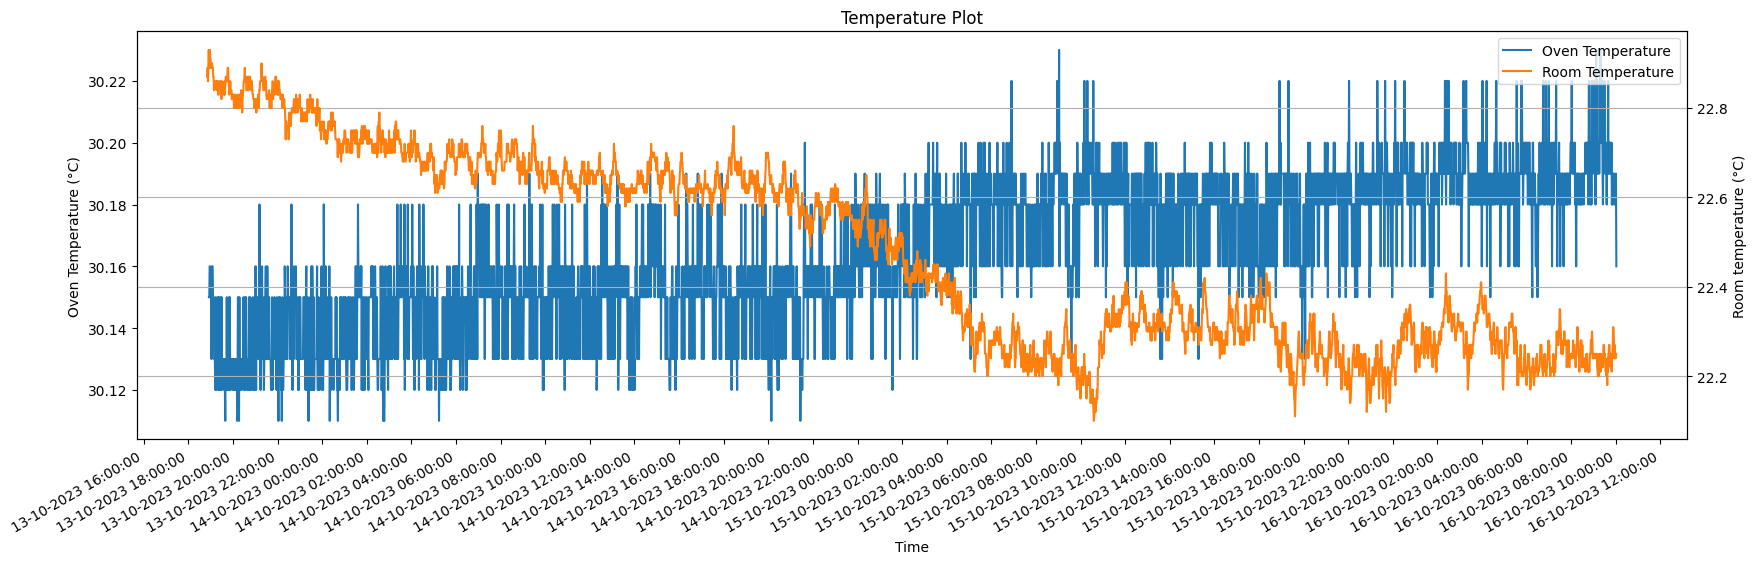

In [168]:
plt.figure(figsize=(20, 6))

# plot them on two twin y axis
line1, = plt.plot(oven_timestamps_trim, oven_temperatures_trim, label='Oven Temperature')
plt.xlabel('Time')
plt.ylabel('Oven Temperature (°C)')
ax2 = plt.twinx()

line2, = ax2.plot(room_timestamps_trim, room_temperatures_trim, label='Room Temperature', color='C1')

plt.title('Temperature Plot') 
ax2.set_ylabel('Room temperature (°C)')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))

plt.grid(True)

# Auto format the x-axis labels to fit them better
plt.gcf().autofmt_xdate()

# Combine lines and labels from both axes to create a single legend
lines = [line1, line2]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels)

plt.show()